<h1> MBA Upload and Download Speed Metric Charts Single TCP Connection </h1>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>

<h7>3/20/22</h7>

In [1]:
# from IPython.core.display import display, HTML
from IPython.display import HTML
from IPython.core.magic import register_cell_magic

@register_cell_magic
def toggle_code(self, cell):
    display(HTML('''
        <script>code_show=true;
        function code_toggle() {
            if (code_show) { $('div.input').hide();}
            else {$('div.input').show();}
            code_show = !code_show
        }
        $(document).ready(code_toggle);
        </script>
        <button onClick="javascript:code_toggle()">Toggle code</button>'''
    ))
    return display(HTML('<p>Click on the button above to show/hide code.</p>'))

In [22]:
%%toggle_code
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from google.cloud import bigquery

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline




print('Executed')

<h3> Bigquery SQL Queries

<h4> Download SQL Queries single TCP Connection

In [25]:
peak_download_sql = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        --PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpget` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpget` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE)) 
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""


fullDay_download_sql = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        -- PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpget` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpget` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))

    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""

# Creating main dataframes
sPeak_download = client.query(peak_download_sql).to_dataframe()
sFullDay_download = client.query(fullDay_download_sql).to_dataframe()
print("Executed")



Executed


<h4> Upload SQL Queries Single TCP Connection

In [24]:
peak_upload_sql = """

SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(16)] as _16_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (SELECT
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httppost` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))    
        ) 
GROUP BY mt_upload, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_upload
) as queryA

JOIN

(SELECT DISTINCT 
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_upload as INT64)) as _80_80_,
FROM
    (SELECT
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httppost` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))    
    ) 
    ORDER BY mt_upload
) as queryB

ON queryA.upload_service_tier = queryB.upload_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech
ORDER BY queryA.upload_service_tier, queryA.ISP, queryA.tech

"""

fullDay_upload_sql = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(16)] as _16_pct_Mbps,
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (SELECT
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httppost` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_upload, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_upload
) as queryA

JOIN

(SELECT DISTINCT 
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_upload as INT64)) as _80_80_,
FROM
    (SELECT
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        FROM
        `broadband-data.mba_data.curr_httppost` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
    ORDER BY mt_upload
) as queryB

ON queryA.upload_service_tier = queryB.upload_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech
ORDER BY queryA.upload_service_tier, queryA.ISP, queryA.tech


"""

sPeak_upload = client.query(peak_upload_sql).to_dataframe()
sFullDay_upload = client.query(fullDay_upload_sql).to_dataframe()
print("Executed")

Executed


<h4> Download SQL Queries Multiple TCP Connections

In [28]:
# DOWNLOAD***

peak_download_sql = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    -- APPROX_QUANTILES(_80_pct/125000, 100)[OFFSET(20)] as _80_80_,    
    --APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(16)] as _16_pct_Mbps,
    -- PERCENTILE_CONT(_80_pct,.20) OVER (PARTITION BY mt_ISP, httpmt_unit_id) order by httpmt_bytes_sec , 
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        --PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE)) 
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""

fullDay_download_sql = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    -- APPROX_QUANTILES(_80_pct/125000, 100)[OFFSET(20)] as _80_80_,    
    -- PERCENTILE_CONT(_80_pct,.20) OVER (PARTITION BY mt_ISP, httpmt_unit_id) order by httpmt_bytes_sec , 
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        -- PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))

    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""


# Creating main dataframes
peak_download = client.query(peak_download_sql).to_dataframe()
fullDay_download = client.query(fullDay_download_sql).to_dataframe()
print("Executed")

Executed


<h4> Upload SQL Queries Multiple TCP Connections

<h4 Download SQL Queries Multiple TCP Connections

In [29]:
peak_upload_sql = """

SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    -- APPROX_QUANTILES(_80_pct/125000, 100)[OFFSET(20)] as _80_80_,    
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(16)] as _16_pct_Mbps,
    -- PERCENTILE_CONT(_80_pct,.20) OVER (PARTITION BY mt_ISP, httpmt_unit_id) order by httpmt_bytes_sec , 
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httppostmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))    
        ) 
GROUP BY mt_upload, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_upload
) as queryA

JOIN

(SELECT DISTINCT 
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_upload as INT64)) as _80_80_,
FROM
    (select
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httppostmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))    
    ) 
    ORDER BY mt_upload
) as queryB

ON queryA.upload_service_tier = queryB.upload_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech
ORDER BY queryA.upload_service_tier, queryA.ISP, queryA.tech

"""

fullDay_upload_sql = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    -- APPROX_QUANTILES(_80_pct/125000, 100)[OFFSET(20)] as _80_80_,    
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(16)] as _16_pct_Mbps,
    -- PERCENTILE_CONT(_80_pct,.20) OVER (PARTITION BY mt_ISP, httpmt_unit_id) order by httpmt_bytes_sec , 
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httppostmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_upload, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_upload
) as queryA

JOIN

(SELECT DISTINCT 
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_upload as INT64)) as _80_80_,
FROM
    (select
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httppostmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
    ORDER BY mt_upload
) as queryB

ON queryA.upload_service_tier = queryB.upload_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech
ORDER BY queryA.upload_service_tier, queryA.ISP, queryA.tech


"""

peak_upload = client.query(peak_upload_sql).to_dataframe()
fullDay_upload = client.query(fullDay_upload_sql).to_dataframe()
print("Executed")

Executed


<hr>

<H5> Python functions

In [10]:
def dfNormalizerD(df):
    
    ispTech =  df['download_service_tier'].astype(str) +"\n"+ df['ISP'] +"\n"+ df['tech']       
    tech = df['tech']
    avg = df['avg_Mbps']
    median = df['median_Mbps']
    twentypct = df['low_20_pct_Mbps']
    fivepct = df['low_5_pct_Mbps']
    eightyeighty = df['_80_80_']
    tier = df['download_service_tier']
    isp = df['ISP']
    
    result = pd.DataFrame(dict(tier=tier, ispTech=ispTech, tech=tech, isp=isp, avg = avg, median = median, twentypct = twentypct, 
                               fivepct = fivepct, eightyeighty = eightyeighty ))
    
    result['avg'] = (result['avg']/result['tier']) *100
    result['median'] = (result['median']/result['tier']) *100
    result['twentypct'] = (result['twentypct']/result['tier']) *100
    result['fivepct'] = (result['fivepct']/result['tier']) *100
    result['eightyeighty'] = (result['eightyeighty']/result['tier']) *100
    
    return result

def dfNormalizerU(df):
    
    ispTech =  df['upload_service_tier'].astype(str) +"\n"+ df['ISP'] +"\n"+ df['tech']   
    tech = df['tech']
    avg = df['avg_Mbps']
    median = df['median_Mbps']
    twentypct = df['low_20_pct_Mbps']
    fivepct = df['low_5_pct_Mbps']
    eightyeighty = df['_80_80_']
    tier = df['upload_service_tier'] 
    isp = df['ISP']
        
    result = pd.DataFrame(dict(tier=tier, ispTech=ispTech, tech=tech, isp=isp, avg = avg, median = median, twentypct = twentypct, 
                               fivepct = fivepct, eightyeighty = eightyeighty))
    
    result['avg'] = (result['avg']/result['tier']) *100
    result['median'] = (result['median']/result['tier']) *100
    result['twentypct'] = (result['twentypct']/result['tier']) *100
    result['fivepct'] = (result['fivepct']/result['tier']) *100
    result['eightyeighty'] = (result['eightyeighty']/result['tier']) *100
    
    return result
    

In [42]:
# Single TCP Dataframes
sPeakDChart = dfNormalizerD(sPeak_download) 
sOffPeakDChart = dfNormalizerD(sFullDay_download) 
sPeakUChart = dfNormalizerU(sPeak_upload) 
sOffPeakUChart = dfNormalizerU(sFullDay_upload) 


# Multiple TCP Dataframes
peakDChart = dfNormalizerD(peak_download) 
offPeakDChart = dfNormalizerD(fullDay_download) 
peakUChart = dfNormalizerU(peak_upload) 
offPeakUChart = dfNormalizerU(fullDay_upload) 

In [79]:
mergedDownloadDF = sPeakDChart.merge(peakDChart, how = 'inner', on=['isp', 'tier'])
mergedUploadDF =  sPeakUChart.merge(peakUChart, how = 'inner', on=['isp', 'tier'])
mergedDownloadDF = mergedDownloadDF.rename(columns = {'ispTech_x': 'ispTech', "eightyeighty_x": 'eightyeighty_Single', 
                                           'eightyeighty_y': 'eightyeighty_Mult', 'avg_x':'avgSingle', 
                                            'avg_y': "avgMult", 'median_x': 'medianSingle', 
                                            "median_y":'medianMult', 'twentypct_x': 'twentyPctSingle',
                                            'twentypct_y': 'twentyPctMult', 'fivepct_x': 'fivePctSingle',
                                            'fivepct_y': 'fivePctMult' })

mergedUploadDF = mergedUploadDF.rename(columns = {'ispTech_x': 'ispTech', "eightyeighty_x": 'eightyeighty_Single', 
                                           'eightyeighty_y': 'eightyeighty_Mult', 'avg_x':'avgSingle', 
                                            'avg_y': "avgMult", 'median_x': 'medianSingle', 
                                            "median_y":'medianMult', 'twentypct_x': 'twentyPctSingle',
                                            'twentypct_y': 'twentyPctMult', 'fivepct_x': 'fivePctSingle',
                                            'fivepct_y': 'fivePctMult' })

<h3> Single TCP Download Speed Connection Charts

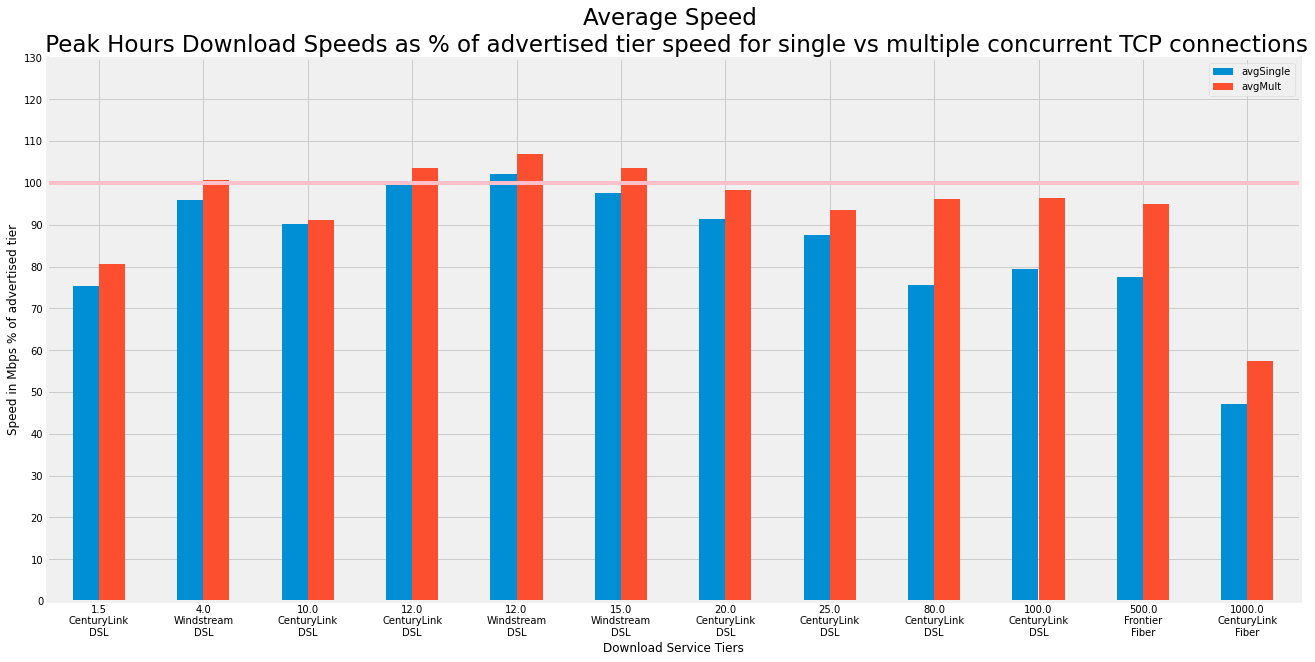

In [75]:
chartData = mergedDownloadDF

ax = chartData.plot(x = "ispTech", y = ['avgSingle', 'avgMult'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Average Speed \n Peak Hours Download Speeds as % of advertised tier speed for single vs multiple concurrent TCP connections', fontsize=23)


plt.show()

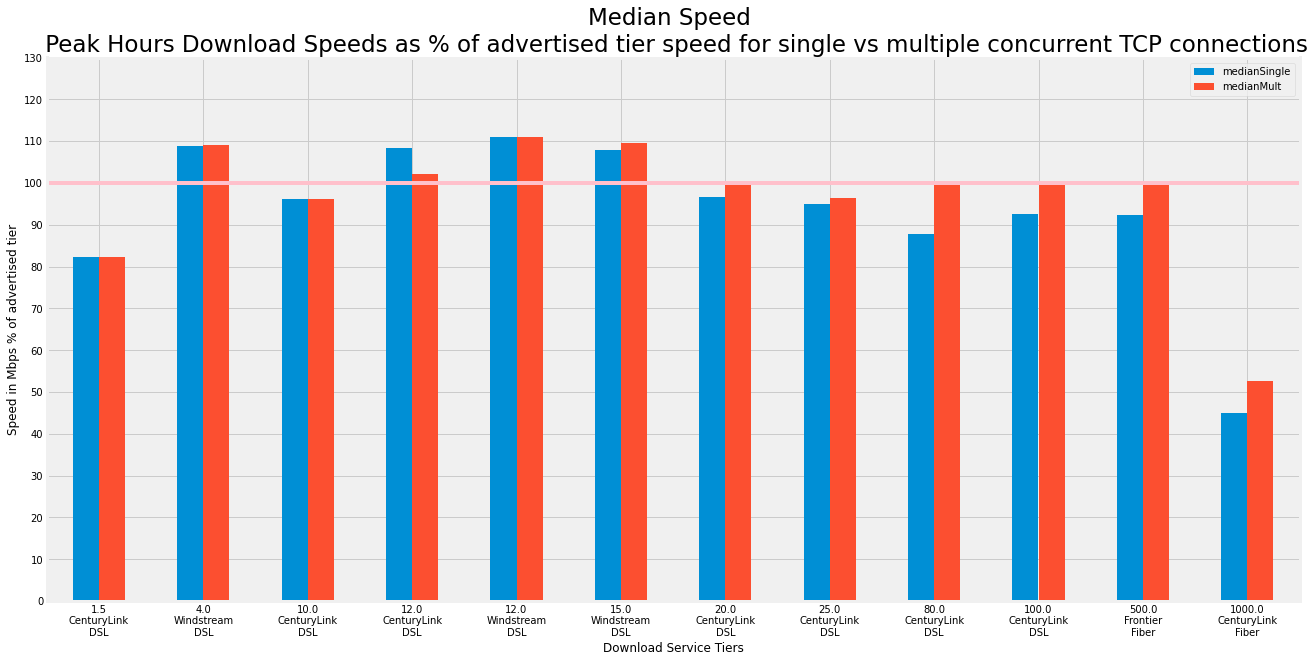

In [76]:
chartData = mergedDownloadDF

ax = chartData.plot(x = "ispTech", y = ['medianSingle', 'medianMult'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Median Speed \n Peak Hours Download Speeds as % of advertised tier speed for single vs multiple concurrent TCP connections', fontsize=23)


plt.show()

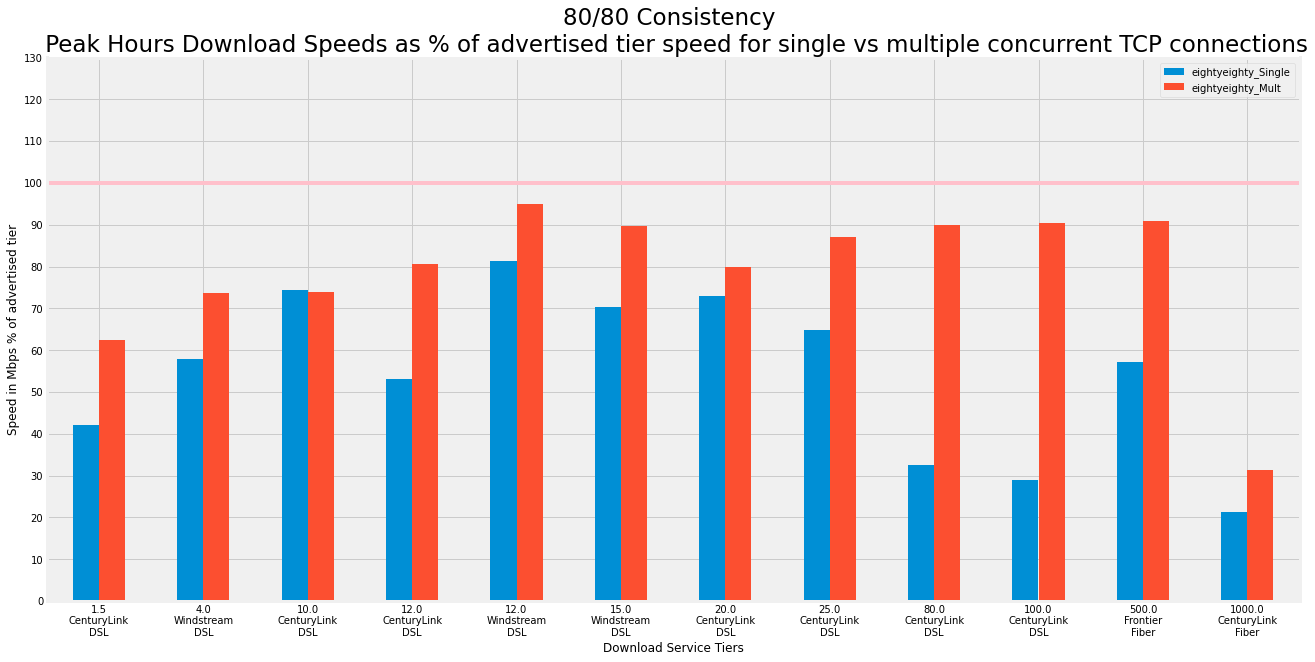

In [93]:
chartData = mergedDownloadDF

ax = chartData.plot(x = "ispTech", y = ['eightyeighty_Single', 'eightyeighty_Mult'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('80/80 Consistency \n Peak Hours Download Speeds as % of advertised tier speed for single vs multiple concurrent TCP connections', fontsize=23)


plt.show()

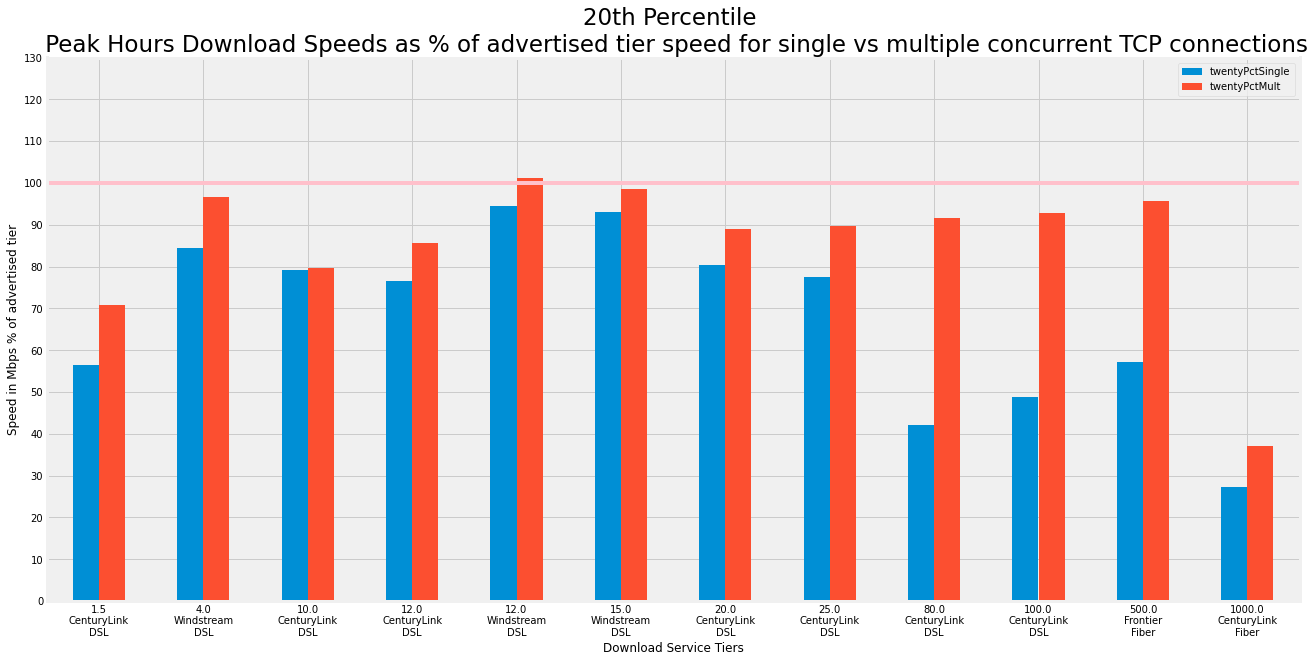

In [80]:
chartData = mergedDownloadDF

ax = chartData.plot(x = "ispTech", y = ['twentyPctSingle', 'twentyPctMult'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('20th Percentile \n Peak Hours Download Speeds as % of advertised tier speed for single vs multiple concurrent TCP connections', fontsize=23)


plt.show()

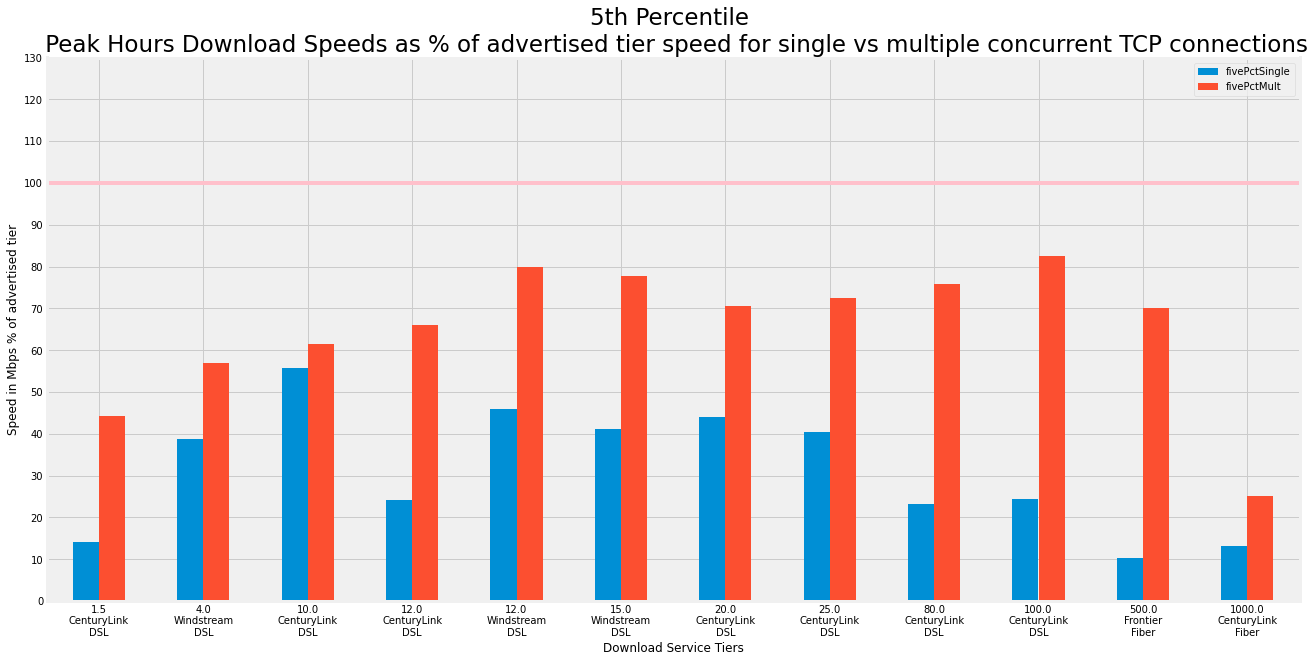

In [82]:
chartData = mergedDownloadDF

ax = chartData.plot(x = "ispTech", y = ['fivePctSingle', 'fivePctMult'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('5th Percentile \n Peak Hours Download Speeds as % of advertised tier speed for single vs multiple concurrent TCP connections', fontsize=23)


plt.show()

<hr>

<h3> Single TCP Upload Speed Connection Charts

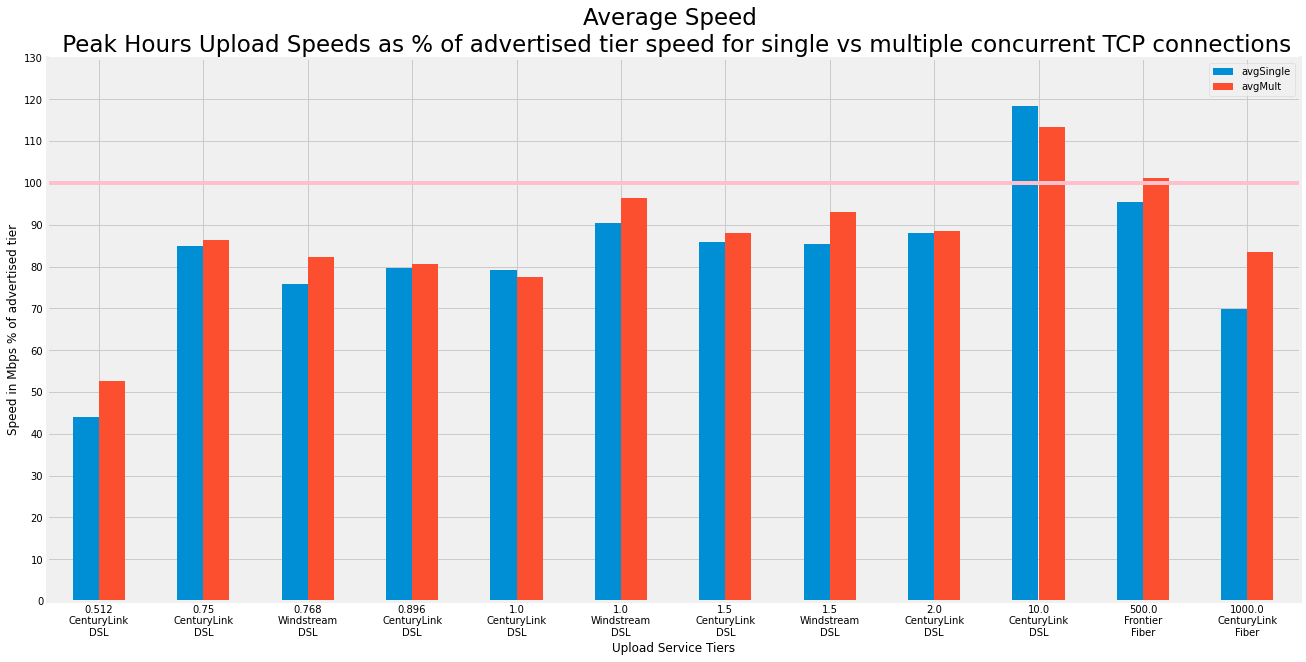

In [91]:
chartData = mergedUploadDF

ax = chartData.plot(x = "ispTech", y = ['avgSingle', 'avgMult'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Average Speed \n Peak Hours Upload Speeds as % of advertised tier speed for single vs multiple concurrent TCP connections', fontsize=23)


plt.show()

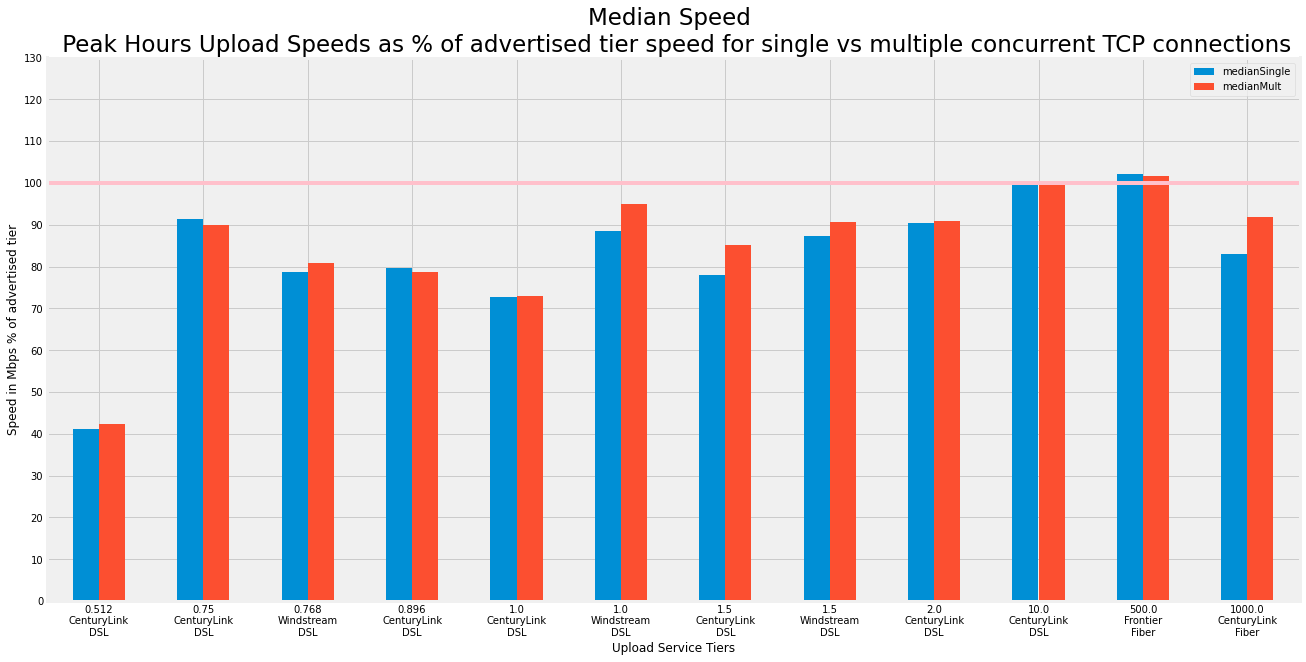

In [90]:
chartData = mergedUploadDF

ax = chartData.plot(x = "ispTech", y = ['medianSingle', 'medianMult'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Median Speed \n Peak Hours Upload Speeds as % of advertised tier speed for single vs multiple concurrent TCP connections', fontsize=23)


plt.show()

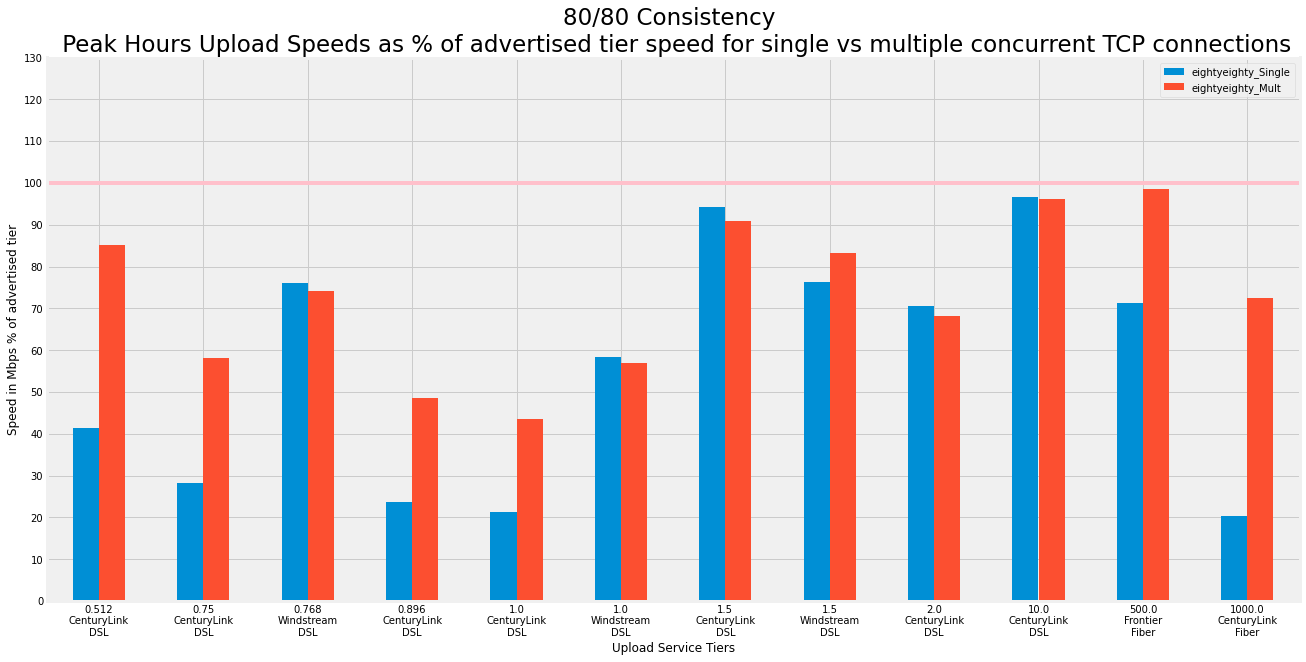

In [92]:
chartData = mergedUploadDF

ax = chartData.plot(x = "ispTech", y = ['eightyeighty_Single', 'eightyeighty_Mult'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('80/80 Consistency \n Peak Hours Upload Speeds as % of advertised tier speed for single vs multiple concurrent TCP connections', fontsize=23)


plt.show()

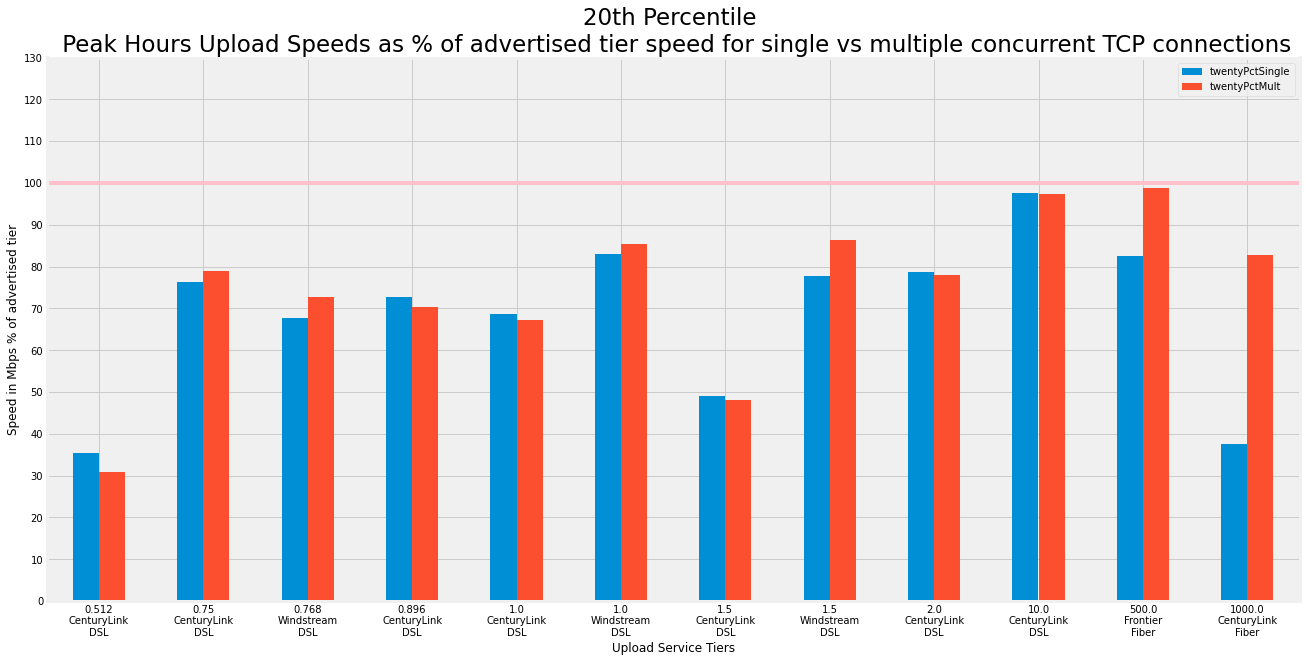

In [88]:
chartData = mergedUploadDF

ax = chartData.plot(x = "ispTech", y = ['twentyPctSingle', 'twentyPctMult'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('20th Percentile \n Peak Hours Upload Speeds as % of advertised tier speed for single vs multiple concurrent TCP connections', fontsize=23)


plt.show()

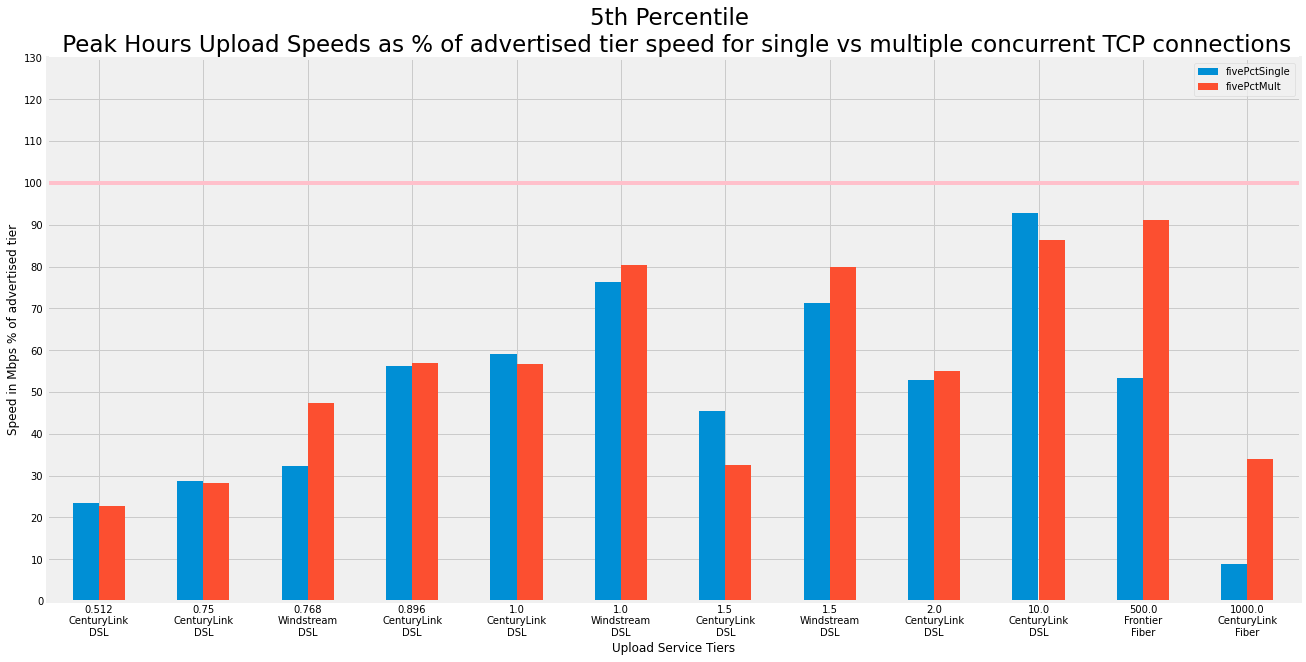

In [87]:
chartData = mergedUploadDF

ax = chartData.plot(x = "ispTech", y = ['fivePctSingle', 'fivePctMult'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('5th Percentile \n Peak Hours Upload Speeds as % of advertised tier speed for single vs multiple concurrent TCP connections', fontsize=23)


plt.show()